In [12]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go
import sys
sys.path.append('../utils')
from helpers import real_gdp_df

plt.style.use('Solarize_Light2')

- **Load GDP data**

In [13]:
GDP_df = real_gdp_df()

# **CPILFESL**

- **Load CPILFESL data**

In [14]:
CPILFESL_df = pd.read_csv('data/CPILFESL.csv')

CPILFESL_df['DATE'] = pd.to_datetime(CPILFESL_df['DATE'])
CPILFESL_df.set_index('DATE', inplace=True)

CPILFESL_df['^ %'] = CPILFESL_df['CPILFESL'].pct_change()

CPILFESL_df.tail()

,CPILFESL,^ %
DATE,,
2024-06-01,318.346,0.000648
2024-07-01,318.872,0.001652
2024-08-01,319.768,0.002810
2024-09-01,320.767,0.003124
2024-10-01,321.666,0.002803


- **Average change**

In [15]:
print(f"Average change is {CPILFESL_df['^ %'].mean() * 100}%")

Average change is 0.2988511557682193%


- **Overview on change**

In [16]:
positive_filter = CPILFESL_df['^ %'] > 0
negative_filter = CPILFESL_df['^ %'] < 0
zero_filter = CPILFESL_df['^ %'] == 0

# count
total_items = len(CPILFESL_df)

# average change
avg_change = [
    CPILFESL_df[positive_filter]['^ %'].mean(),
    CPILFESL_df[negative_filter]['^ %'].mean(),
    0,
    ""
]

# frequency
frequency = [
    CPILFESL_df[positive_filter]['^ %'].count(),
    CPILFESL_df[negative_filter]['^ %'].count(),
    CPILFESL_df[zero_filter]['^ %'].count()
]
frequency.append(frequency[0]/frequency[1])

# frequency pct
frequency_pct = [100 * frequency[i]/total_items for i in range(3)]
frequency_pct.append("")

# Prob adj
prob_adj = [frequency_pct[i] * avg_change[i] for i in range(3)]
prob_adj.append("")

pd.DataFrame({
    "%": [x * 100 for x in avg_change],
    "Frequency": frequency,
    "Frequency %": frequency_pct,
    "Prob Adjust % Change": prob_adj,
}, index=["Av Pos", "Av Neg", "Zero", "Ratio P/N"])

,%,Frequency,Frequency %,Prob Adjust % Change
Av Pos,0.336569,729.00,89.55774,0.301424
Av Neg,-0.199403,12.00,1.474201,-0.00294
Zero,0,72.00,8.845209,0.0
Ratio P/N,,60.75,,


- **Stats**

In [17]:
from scipy.stats import describe

# Display the results

stats = describe(CPILFESL_df['^ %'].dropna().tolist())
pd.DataFrame(
    {
        'value': [
            str(stats.nobs),
            stats.minmax[0] * 100,
            stats.minmax[1] * 100,
            stats.mean * 100,
            CPILFESL_df['^ %'].median() * 100,
            CPILFESL_df['^ %'].mode(dropna=True)[0] * 100,
            stats.variance,
            stats.skewness,
            stats.kurtosis
        ]
    },
    index=['nobs', 'Min %', 'Max %', 'Mean %', "Median %", "Mode %", 'Variance', 'Skewness', 'Kurtosis'],
)

,value
nobs,813
Min %,-0.476283
Max %,1.419355
Mean %,0.298851
Median %,0.256472
Mode %,0.0
Variance,0.000006
Skewness,1.307835
Kurtosis,3.027254


- **Data preview**

In [18]:
# Define bins
bins = [0.005 * i for i in range(0, 3)]
bins.append(stats.minmax[1])
bins.insert(0, stats.minmax[0])
bin_labels = [
    f"{round(bins[0] * 100, 3)}% to 0%",
    '0% to 0.5%',
    '0.5% to 1%',
    f"1% to {round(bins[-1] * 100, 3)}%",
]

# Assign data to bins
binned = pd.cut(CPILFESL_df['^ %'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate frequency, probability, and cumulative probability
frequency = binned.value_counts().sort_index()
probability = 100 * frequency / frequency.sum()
cumulative_probability = probability.cumsum()

occurrence_frequencies = pd.DataFrame({
    'Frequency': frequency.values,
    'Probability %': probability.values,
    'Cumulative Probability %': cumulative_probability.values
}, index=bin_labels)

occurrence_frequencies

,Frequency,Probability %,Cumulative Probability %
-0.476% to 0%,84,10.332103,10.332103
0% to 0.5%,592,72.816728,83.148831
0.5% to 1%,118,14.514145,97.662977
1% to 1.419%,19,2.337023,100.000000


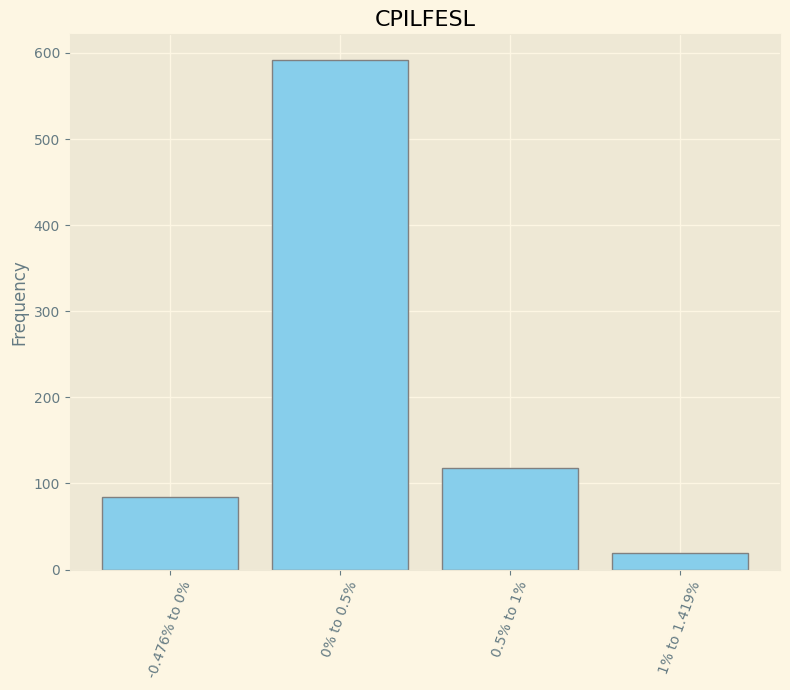

In [19]:
plt.figure(figsize=(8, 7))

plt.bar(occurrence_frequencies.index, occurrence_frequencies['Frequency'], color='skyblue', edgecolor='gray')

# Add labels and title
plt.title('CPILFESL')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation=70) 
# Show the chart
plt.tight_layout()
plt.show();

- CPILFESL pct change

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=CPILFESL_df.index, 
    y=[100 * stats.mean] * (stats.nobs + 1), 
    name='PMI 50 Points',
    line=dict(width=2),
    hoverinfo="skip",
    showlegend=False,
    marker=dict(color='red'),
))

fig.add_trace(go.Bar(
    x=CPILFESL_df.index,
    y=CPILFESL_df['^ %'] * 100,
    name='CPILFESL',
    marker=dict(line=dict(color='rgba(0, 0,250, .9)', width=2)),
    width=0.5,
))

fig.update_layout(
    title=dict(text='CPILFESL pct change'),
    plot_bgcolor='rgb(230, 230,230)',
    width=1400,
    height=700,
    yaxis=dict(title="%", exponentformat="none", showgrid=False),
    barmode="group",
    xaxis=dict(showgrid=False),
)

fig.show()

- **CPILFESL data plot**

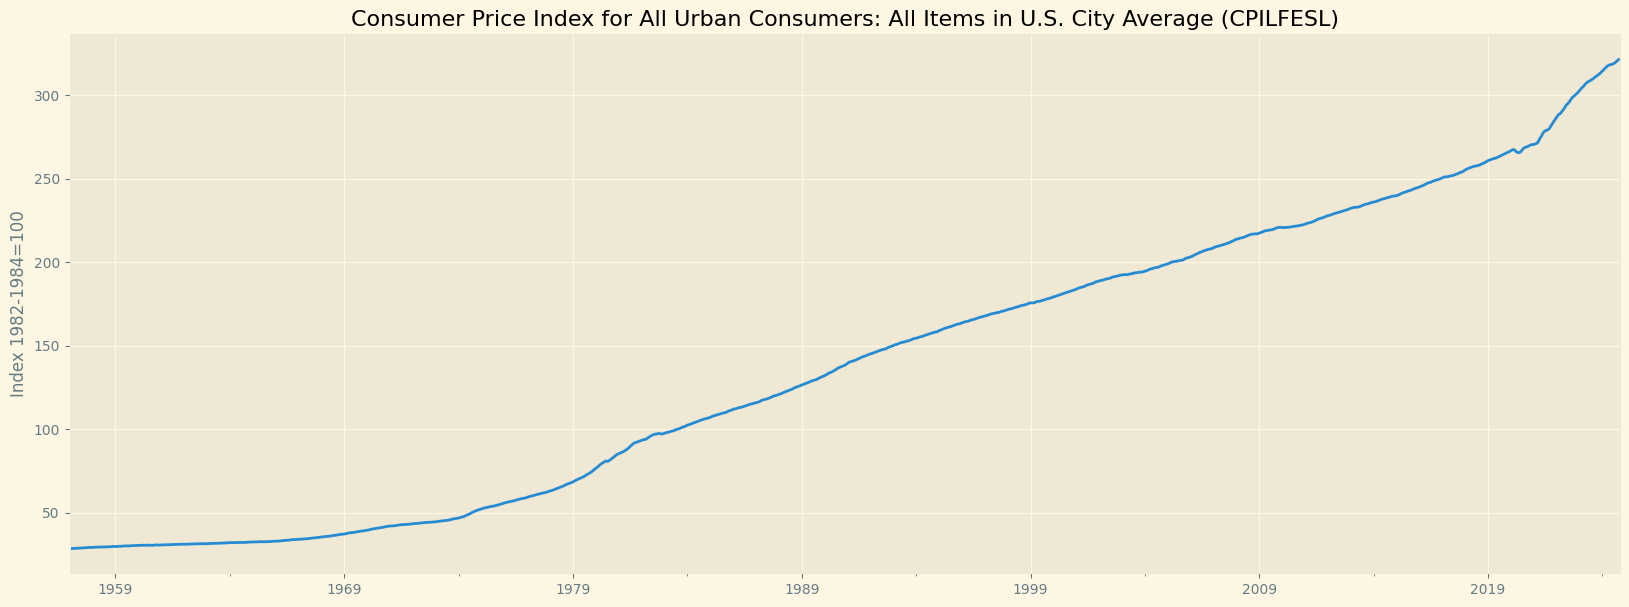

In [21]:
CPILFESL_df['CPILFESL'].plot(
    figsize=(20, 7),
    xlabel='',
    ylabel='Index 1982-1984=100',
    title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPILFESL)',
);

- **CPILFESL vs GDP Growth**

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=CPILFESL_df.index,
    y=CPILFESL_df['^ %'] * 100,
    name='CPILFESL',
    fill='tonexty',
    fillcolor='rgba(109,215,253, 0.9)',
    line=dict(color='rgba(109,215,253, 0.9)', width=1),
))

fig.add_trace(go.Bar(
    x=GDP_df.index,
    y=GDP_df['GDP'],
    name='GDP',
    yaxis="y2",
    marker=dict(line=dict(color='red', width=2)),
    width=0.5,
))

# ------------------------------------------------------------------------
level_a = 0  # Level on left y-axis
level_b = 0  # Matching level on right y-axis

# Define the ranges for each axis
range_left = [(CPILFESL_df['^ %'] * 100).min(), (CPILFESL_df['^ %'] * 100).max()]  # Min and max for right y-axis (to be adjusted)
range_right = [GDP_df['GDP'].min(), GDP_df['GDP'].max()]  # Min and max for left y-axis

# Calculate scaling factor to align levels
proportion = (level_a - range_left[0]) / (range_left[1] - range_left[0])  # Position of level_a
range_right[1] = range_right[0] + (level_b - range_right[0]) / proportion  # Adjust right range
# ------------------------------------------------------------------------

fig.update_layout(
    title=dict(text='CPILFESL vs GDP Growth'),
    plot_bgcolor='rgb(0, 0, 0)',
    width=1400,
    height=700,
    # hovermode="y unified",
    yaxis=dict(title="CPILFESL pct change %", exponentformat="none", range=range_left, showgrid=False),
    yaxis2=dict(title="Real GDP change in %", overlaying="y", side="right", range=range_right, showgrid=False),
    barmode="group",
    legend=dict(x=0.5, y=-0.2, orientation="h"),
    xaxis=dict(showgrid=False),
)

fig.show()